## Finding Nearest Neighbours on videos 

### Total number of videos : 40

In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np

In [2]:
import json
import os
from moviepy.editor import *
from moviepy import *
import shutil
import numpy as np
import cv2
import tempfile

In [3]:
import matplotlib.pyplot as plt

In [4]:
from PIL import Image

In [5]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

In [6]:
from IPython.display import Image as iImage
from IPython.display import display

In [7]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [8]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

2023-02-09 10:08:11.831274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def process_image(image_path, model):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Pre-process the image for the model
    # You can add your own pre-processing steps here
    image = cv2.resize(image, (224,224))
    image = np.expand_dims(image, axis=0)

    # Use the model to predict the features for the image
    features = model.predict(image)

    # Return the features
    return features

In [10]:
import os
import cv2
import tempfile

def process_video(video_path, model):
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create a list to store the features for each frame
    features = []

    # Read each frame from the video
    for i in range(total_frames):
        # Read the next frame
        ret, frame = cap.read()

        # If there are no more frames, break the loop
        if not ret:
            break

        # Write the frame to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.jpg') as temp:
            cv2.imwrite(temp.name, frame)
            # Process the temporary image file
            f = process_image(temp.name, model)

        # Append the features for the current frame to the list
        features.append(f[0].flatten())

    # Release the video capture object
    cap.release()

    # Return the features for all the frames in the video
    return features

In [11]:
video_dir = '/Users/mansikothari/Documents/UD_MARCH/RC_11/Skills_Class/SkillsClasses_Assignment/01_Julian/04_DesignAlgorithms/trial'
videos = os.listdir(video_dir)

In [28]:
all_filenames = []
all_features = []
for video in videos:
    video_path = os.path.join(video_dir, video)
    features = process_video(video_path, model)
    all_features.append(features)
    all_filenames.append(video)

In [32]:
all_features

[[array([0.1278506 , 0.16035707, 0.24744722, ..., 1.3361012 , 0.        ,
         0.3157653 ], dtype=float32),
  array([0.1908811 , 0.15142901, 0.12533338, ..., 0.9629111 , 0.        ,
         0.22911566], dtype=float32),
  array([0.30926606, 0.2651507 , 0.17796333, ..., 1.2761737 , 0.        ,
         0.09861075], dtype=float32),
  array([0.36369696, 0.18845348, 0.05266308, ..., 1.1509317 , 0.01677651,
         0.03066883], dtype=float32),
  array([0.17381203, 0.15081993, 0.12402877, ..., 1.6700039 , 0.        ,
         0.18219568], dtype=float32),
  array([0.282854  , 0.21822011, 0.0156284 , ..., 0.88633966, 0.        ,
         0.26419207], dtype=float32),
  array([0.16956566, 0.0332651 , 0.22369564, ..., 0.47212994, 0.        ,
         0.1573722 ], dtype=float32),
  array([0.25255215, 0.3027907 , 0.5301088 , ..., 0.5790889 , 0.        ,
         0.06278212], dtype=float32),
  array([0.30314925, 0.35292584, 0.30869982, ..., 1.0949581 , 0.01792037,
         0.3153718 ], dtype=fl

In [30]:
len(all_features)

40

In [44]:
def pad_features(all_features):
    max_len = max([len(x) for x in all_features])
    for i in range(len(all_features)):
        if isinstance(all_features[i], list):
            all_features[i] = np.array(all_features[i])
        if all_features[i].shape[0] < max_len:
            padding = np.zeros((max_len - all_features[i].shape[0], all_features[i].shape[1]))
            all_features[i] = np.concatenate((all_features[i], padding), axis=0)
    return np.stack(all_features, axis=0)


In [46]:
all_features = pad_features(all_features)

In [48]:
input_data = np.stack(all_features, axis=0)
input_data = input_data.reshape(input_data.shape[0], -1)

In [49]:
# Fit the nearest neighbors algorithm to the input data
nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(input_data)

# Find the nearest neighbors for each feature
distances, indices = nbrs.kneighbors(input_data)

In [50]:
len(all_features)

40

In [51]:
indices

array([[ 0, 20, 11],
       [ 1, 16, 14],
       [ 2,  8, 10],
       [ 3, 18, 11],
       [ 4, 18, 11],
       [ 5, 17, 25],
       [ 6,  5, 17],
       [ 7, 32, 11],
       [ 8,  2, 13],
       [ 9, 39, 27],
       [10, 25, 17],
       [11, 29, 34],
       [12, 30, 25],
       [13, 25, 21],
       [14, 39, 19],
       [15,  4, 34],
       [16, 27, 39],
       [17,  5, 25],
       [18,  4, 30],
       [19, 22, 39],
       [20,  0, 11],
       [21, 11, 29],
       [22, 39, 19],
       [23, 28, 37],
       [24, 39, 27],
       [25, 17, 30],
       [26, 11, 29],
       [27, 39, 19],
       [28,  4, 18],
       [29, 11, 34],
       [30, 34, 18],
       [31, 18, 11],
       [32,  4, 30],
       [33, 34, 18],
       [34, 30, 11],
       [35,  3, 17],
       [36, 11, 29],
       [37, 33, 26],
       [38,  4, 32],
       [39, 14, 27]])

In [52]:
len(indices)

40

In [53]:
len(videos)

40

In [54]:
from ipywidgets import Video

In [55]:
def showNearestNeighbours(index, indices, videos, path):
    for i in indices[index]:
        f = videos[i]
        print(f)
        display(Video(filename = os.path.join(path, f)))

In [56]:
showNearestNeighbours(2, indices, videos, '/Users/mansikothari/Documents/UD_MARCH/RC_11/Skills_Class/SkillsClasses_Assignment/01_Julian/04_DesignAlgorithms/trial')

fragment02.mp4


Video(value=b'')

fragment01.mp4


Video(value=b'')

fragment05.mp4


Video(value=b'')

In [57]:
distances

array([[0.00000000e+00, 1.22252545e+02, 1.53461914e+02],
       [0.00000000e+00, 2.43345691e+02, 2.44457613e+02],
       [0.00000000e+00, 1.64184414e+02, 1.78028995e+02],
       [0.00000000e+00, 1.60004738e+02, 1.61052979e+02],
       [0.00000000e+00, 1.37955403e+02, 1.49600560e+02],
       [0.00000000e+00, 1.24818735e+02, 1.52082786e+02],
       [0.00000000e+00, 1.89716066e+02, 1.91684014e+02],
       [0.00000000e+00, 1.62564601e+02, 1.70556972e+02],
       [0.00000000e+00, 1.64184414e+02, 1.90783389e+02],
       [0.00000000e+00, 1.59213076e+02, 1.67153031e+02],
       [0.00000000e+00, 1.75169598e+02, 1.76313438e+02],
       [0.00000000e+00, 7.55271525e-05, 1.42057725e+02],
       [0.00000000e+00, 1.67404734e+02, 1.75069420e+02],
       [0.00000000e+00, 1.69782929e+02, 1.74489282e+02],
       [0.00000000e+00, 1.43188341e+02, 1.60041754e+02],
       [0.00000000e+00, 1.50670789e+02, 1.51417064e+02],
       [0.00000000e+00, 1.78468127e+02, 1.85175394e+02],
       [0.00000000e+00, 1.24818

In [58]:
G = nx.Graph()

In [59]:
for i in videos:
    G.add_node(i)

In [60]:
def createEdges(indices, files, distances):
    weightedEdges = []
    for i in range(len(indices)):
        index = indices[i]
        dist = distances[i][1:]
        
        node = files[index[0]]
        
        edges = []
        print(dist)
        for e in index[1:]:
            edges.append(files[e])
        
        for i in range(len(edges)):
            weightedEdges.append((node, edges[i], dist[i]))
    
    return weightedEdges

In [61]:
edges = createEdges(indices, all_filenames, distances)

[122.25254473 153.46191353]
[243.34569079 244.45761343]
[164.18441382 178.02899514]
[160.00473755 161.05297854]
[137.9554033  149.60056003]
[124.81873488 152.08278622]
[189.71606622 191.68401402]
[162.56460145 170.55697154]
[164.18441382 190.78338881]
[159.21307647 167.15303113]
[175.16959788 176.31343802]
[7.55271525e-05 1.42057725e+02]
[167.40473359 175.06942039]
[169.78292914 174.48928226]
[143.1883407  160.04175376]
[150.67078894 151.41706399]
[178.46812745 185.1753938 ]
[124.81873488 146.46688808]
[137.9554033  139.48746786]
[148.7048708  149.85626819]
[122.25254473 148.55230618]
[150.37327047 150.37327047]
[147.07442424 148.7048708 ]
[212.2513951  221.67158497]
[149.24983095 155.31066124]
[146.46688808 147.60414352]
[157.77300954 157.77300954]
[144.04087574 153.30219237]
[178.16279913 178.98723625]
[7.55271525e-05 1.42057725e+02]
[138.50563566 139.48746786]
[172.68345464 172.9190869 ]
[154.41275303 154.71605841]
[159.36131353 160.45108088]
[138.50563566 142.05772491]
[176.2726508

In [62]:
edges

[('fragment17.mp4', 'fragment22.mp4', 122.25254472725211),
 ('fragment17.mp4', 'fragment11.mp4', 153.46191353029968),
 ('fragment03.mp4', 'fragment06.mp4', 243.34569079124364),
 ('fragment03.mp4', 'fragment38.mp4', 244.4576134331801),
 ('fragment02.mp4', 'fragment01.mp4', 164.18441382135066),
 ('fragment02.mp4', 'fragment05.mp4', 178.02899514142194),
 ('fragment16.mp4', 'fragment13.mp4', 160.00473755117324),
 ('fragment16.mp4', 'fragment11.mp4', 161.05297854122912),
 ('fragment14.mp4', 'fragment13.mp4', 137.95540330188157),
 ('fragment14.mp4', 'fragment11.mp4', 149.60056003033088),
 ('fragment28.mp4', 'fragment07.mp4', 124.81873487669758),
 ('fragment28.mp4', 'fragment09.mp4', 152.08278622151676),
 ('fragment29.mp4', 'fragment28.mp4', 189.7160662174234),
 ('fragment29.mp4', 'fragment07.mp4', 191.68401402402756),
 ('fragment15.mp4', 'fragment31.mp4', 162.56460144545412),
 ('fragment15.mp4', 'fragment11.mp4', 170.55697153827552),
 ('fragment01.mp4', 'fragment02.mp4', 164.18441382135066),

In [63]:
G.add_weighted_edges_from(edges)

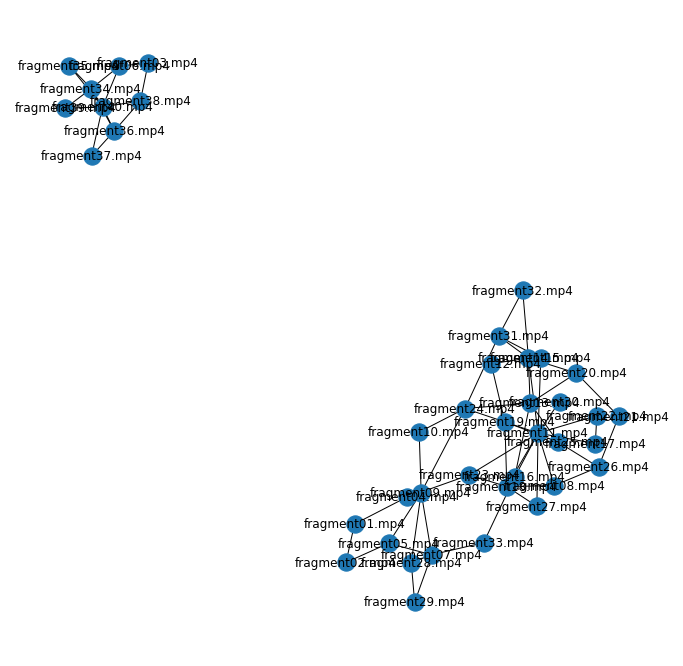

In [64]:
fig, ax = plt.subplots(figsize = (12,12))
nx.draw(G, with_labels=True)

In [65]:
T = nx.minimum_spanning_tree(G)

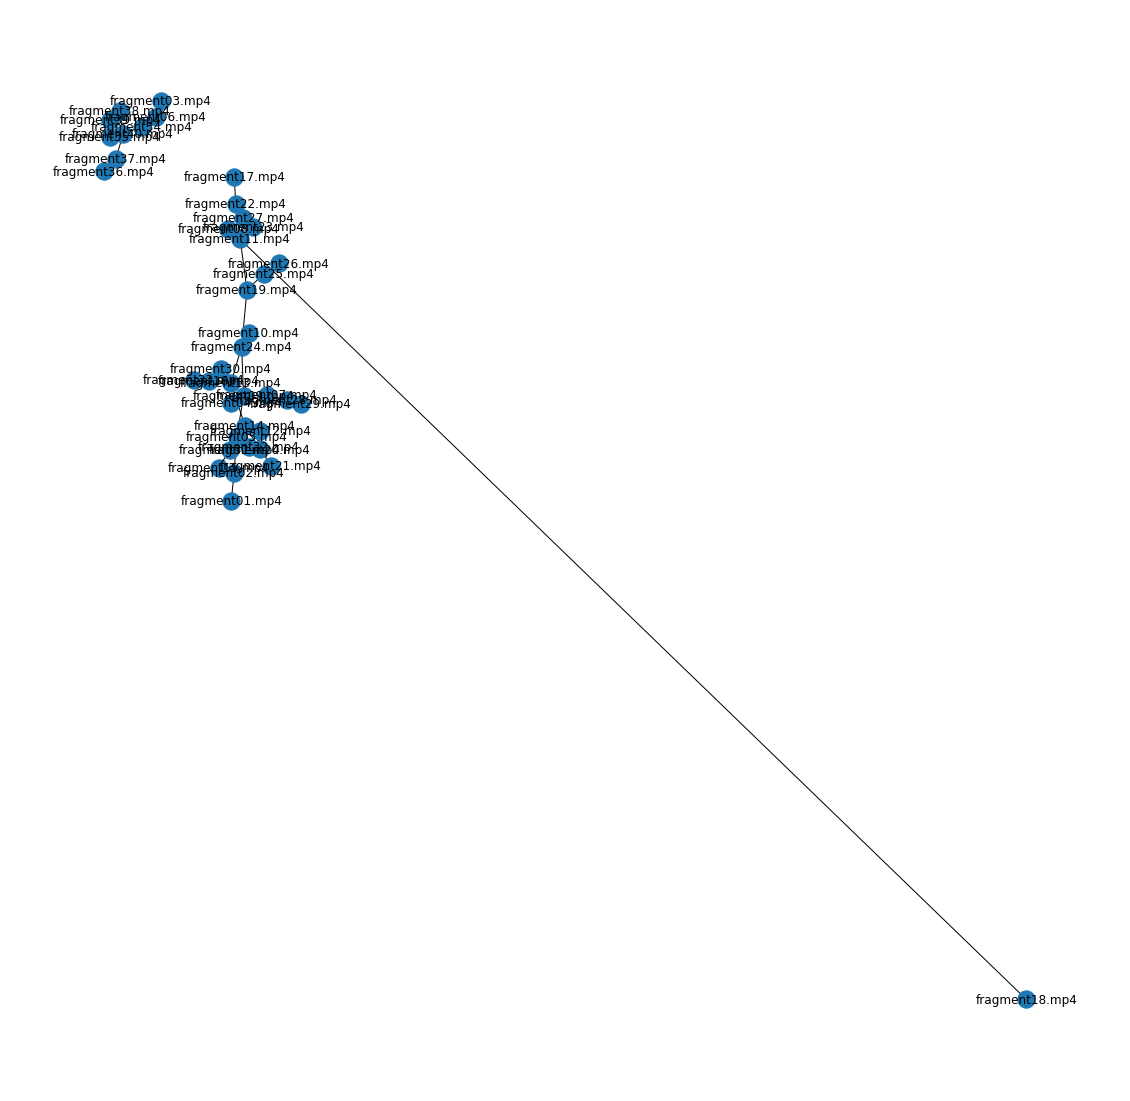

In [66]:
fig, ax = plt.subplots(figsize = (20,20))
nx.draw(T,with_labels=True)